In [1]:
import numpy as np
import pandas as pd
import os
import torch 
import torch.nn as nn
import glob
import matplotlib.pyplot as plt
import random
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import albumentations as A
from albumentations.pytorch import ToTensor, ToTensorV2
from collections import OrderedDict
from sklearn.model_selection import train_test_split
import cv2
from torch.optim.lr_scheduler import StepLR

ModuleNotFoundError: No module named 'sklearn'

In [3]:
DATA_PATH = "/kaggle/input/lgg-mri-segmentation/kaggle_3m/"

# File path line length images for later sorting
BASE_LEN = 89 # len(/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_ <-!!!43.tif)
END_IMG_LEN = 4 # len(/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_43 !!!->.tif)
END_MASK_LEN = 9 # (/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_43 !!!->_mask.tif)

# img size
IMG_SIZE = 256

data_map = []
for sub_dir_path in glob.glob(DATA_PATH+"*"):
    if os.path.isdir(sub_dir_path):
        dirname = sub_dir_path.split("/")[-1]
        for filename in os.listdir(sub_dir_path):
            image_path = sub_dir_path + "/" + filename
            data_map.extend([dirname, image_path])
    else:
        print("This is not a dir:", sub_dir_path)
        
        
df = pd.DataFrame({"dirname" : data_map[::2],
                  "path" : data_map[1::2]})
df.head()

This is not a dir: /kaggle/input/lgg-mri-segmentation/kaggle_3m/README.md
This is not a dir: /kaggle/input/lgg-mri-segmentation/kaggle_3m/data.csv


,dirname,path
0,TCGA_DU_7304_19930325,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
1,TCGA_DU_7304_19930325,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
2,TCGA_DU_7304_19930325,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
3,TCGA_DU_7304_19930325,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
4,TCGA_DU_7304_19930325,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...


In [4]:
df_imgs = df[~df['path'].str.contains("mask")]
df_masks = df[df['path'].str.contains("mask")]

# Data sorting
imgs = sorted(df_imgs["path"].values, key=lambda x : int(x[BASE_LEN:-END_IMG_LEN]))
masks = sorted(df_masks["path"].values, key=lambda x : int(x[BASE_LEN:-END_MASK_LEN]))

# Sorting check
idx = random.randint(0, len(imgs)-1)
print("Path to the Image:", imgs[idx], "\nPath to the Mask:", masks[idx])

Path to the Image: /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_50.tif 
Path to the Mask: /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_50_mask.tif


In [5]:
# Final dataframe
df = pd.DataFrame({"patient": df_imgs.dirname.values,
                       "image_path": imgs,
                   "mask_path": masks})


# Adding A/B column for diagnosis
def positiv_negativ_diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    if value > 0 : return 1
    else: return 0

df["diagnosis"] = df["mask_path"].apply(lambda m: positiv_negativ_diagnosis(m))
df



,patient,image_path,mask_path,diagnosis
0,TCGA_DU_7304_19930325,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
1,TCGA_DU_7304_19930325,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
2,TCGA_DU_7304_19930325,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
3,TCGA_DU_7304_19930325,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
4,TCGA_DU_7304_19930325,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
...,...,...,...,...
3924,TCGA_FG_6688_20020215,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
3925,TCGA_FG_6688_20020215,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
3926,TCGA_FG_6688_20020215,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
3927,TCGA_FG_6688_20020215,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0


In [6]:
class BrainMriDataset(Dataset):
    def __init__(self, df, transforms):
        
        self.df = df
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        image = cv2.imread(self.df.iloc[idx, 1])
        mask = cv2.imread(self.df.iloc[idx, 2], 0)
        
        augmented = self.transforms(image=image, 
                                    mask=mask)
 
        image = augmented['image']
        mask = augmented['mask']   
        
        return image, mask
    
        # unnormilize mask
        #mask = torch.clamp(mask.float(), min=0, max=1)
        #mask = torch.ceil(mask)    

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [3]:
PATCH_SIZE=256
transforms = A.Compose([
    A.Resize(width = PATCH_SIZE, height = PATCH_SIZE, p=1.0),
    A.HorizontalFlip(p=0.2),
    A.VerticalFlip(p=0.2),
    A.RandomRotate90(p=0.2),
    A.Transpose(p=0.2),
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=0, p=0.25),

    
    
    A.Normalize(p=1.0),
    ToTensor(),
])


In [9]:
# Split df into train_df and val_df
train_df, val_df = train_test_split(df, stratify=df.diagnosis, test_size=0.1)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

# Split train_df into train_df and test_df
train_df, test_df = train_test_split(train_df, stratify=train_df.diagnosis, test_size=0.15)
train_df = train_df.reset_index(drop=True)

#train_df = train_df[:1000]
print(f"Train: {train_df.shape} \nVal: {val_df.shape} \nTest: {test_df.shape}")

Train: (3005, 4) 
Val: (393, 4) 
Test: (531, 4)


In [10]:
print(train_df.diagnosis.value_counts())
print(val_df.diagnosis.value_counts())
print(test_df.diagnosis.value_counts())

0    1955
1    1050
Name: diagnosis, dtype: int64
0    256
1    137
Name: diagnosis, dtype: int64
0    345
1    186
Name: diagnosis, dtype: int64


In [11]:
train_dataset = BrainMriDataset(df=train_df, transforms=transforms)
train_dataloader = DataLoader(train_dataset, batch_size=26, num_workers=4, shuffle=True)

# val
val_dataset = BrainMriDataset(df=val_df, transforms=transforms)
val_dataloader = DataLoader(val_dataset, batch_size=26, num_workers=4, shuffle=True)

#test
test_dataset = BrainMriDataset(df=test_df, transforms=transforms)
test_dataloader = DataLoader(test_dataset, batch_size=26, num_workers=4, shuffle=True)

torch.Size([26, 3, 256, 256]) torch.Size([26, 1, 256, 256])


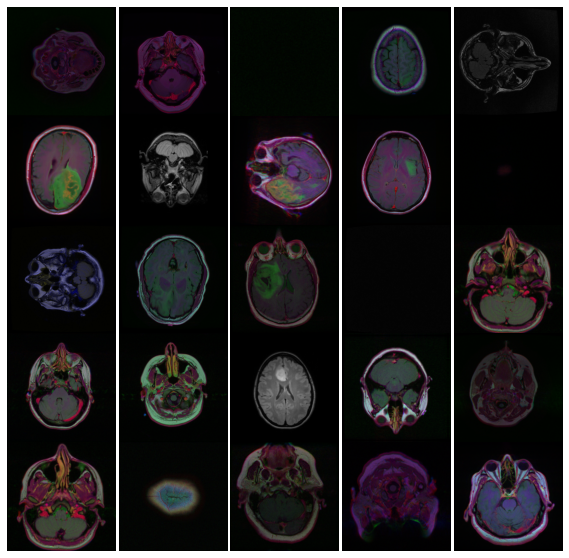

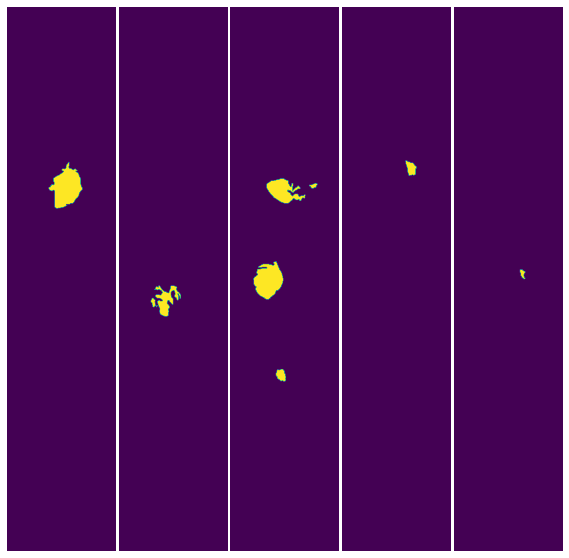

In [12]:
def show_aug(inputs, nrows=5, ncols=5, image=True):
    plt.figure(figsize=(10, 10))
    plt.subplots_adjust(wspace=0., hspace=0.)
    i_ = 0
    
    if len(inputs) > 25:
        inputs = inputs[:25]
        
    for idx in range(len(inputs)):
    
        # normalization
        if image is True:           
            img = inputs[idx].numpy().transpose(1,2,0)
            mean = [0.485, 0.456, 0.406]
            std = [0.229, 0.224, 0.225] 
            img = (img*std+mean).astype(np.float32)
        else:
            img = inputs[idx].numpy().astype(np.float32)
            img = img[0,:,:]
        
        #plot
        #print(img.max(), len(np.unique(img)))
        plt.subplot(nrows, ncols, i_+1)
        plt.imshow(img); 
        plt.axis('off')
 
        i_ += 1
        
    return plt.show()

    
images, masks = next(iter(train_dataloader))
print(images.shape, masks.shape)

show_aug(images)
show_aug(masks, image=False)

In [13]:
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1,bias=False),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1,bias=False),
        nn.ReLU(inplace=True))


In [4]:
class UNet(nn.Module):

    def __init__(self, in_channels=3, out_channels=1, init_features=32):
        super(UNet, self).__init__()

        features = init_features
        self.encoder1 = UNet._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNet._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = UNet._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = UNet._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = UNet._block(features * 8, features * 16, name="bottleneck")

        self.upconv4 = nn.ConvTranspose2d(
            features * 16, features * 8, kernel_size=2, stride=2
        )
        self.decoder4 = UNet._block((features * 8) * 2, features * 8, name="dec4")
        self.upconv3 = nn.ConvTranspose2d(
            features * 8, features * 4, kernel_size=2, stride=2
        )
        self.decoder3 = UNet._block((features * 4) * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(
            features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder2 = UNet._block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(
            features * 2, features, kernel_size=2, stride=2
        )
        self.decoder1 = UNet._block(features * 2, features, name="dec1")

        self.conv = nn.Conv2d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )

    def forward(self, x):
        #print(x.shape)
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        #print(dec1.shape)
        return torch.sigmoid(self.conv(dec1))

    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        name + "conv1",
                        nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm1", nn.BatchNorm2d(num_features=features)),
                    (name + "relu1", nn.ReLU(inplace=True)),
                    (
                        name + "conv2",
                        nn.Conv2d(
                            in_channels=features,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm2", nn.BatchNorm2d(num_features=features)),
                    (name + "relu2", nn.ReLU(inplace=True)),
                ]
            )
        )

In [5]:
model=UNet()
a=model(torch.rand(1,3,256,256))
print(a.shape)

torch.Size([1, 1, 256, 256])


In [15]:
def dice_loss(pred,target,e=1e-6):
    inter=2*(pred*target).sum()+e
    union=(pred).sum()+(target).sum()+e
    return 1-(inter/union).sum()

def bce_dice_loss(inputs, target):
    dicescore = dice_loss(inputs, target)
    bcescore = nn.BCELoss()
    bceloss = bcescore(inputs, target)
    
    return dicescore+bceloss

In [165]:
bce_dice_loss(torch.tensor([0.7,1.,1.]),torch.tensor([1.,1.,1.]))

tensor(0.1715)

In [166]:
dice_loss(torch.tensor([0.7,1.,1.]),torch.tensor([1.,1.,1.]))

tensor(0.0526)

In [19]:
def train(model,optimizer,epoch,lr_schedular,train_loader):
    model.train()
    loss_collection=0
    total_size=0
    for i,(img,lab) in enumerate(train_loader):
        optimizer.zero_grad()
        img,lab=img.to(device),lab.to(device)
        pred=model(img)
        loss=bce_dice_loss(pred,lab)
        loss_collection+=loss.item()
        total_size += img.size(0)
        loss.backward()
        optimizer.step()
        if i%50==0:
            lr_schedular.step()
            print("\n Learning rate is {}".format(lr_schedular.get_last_lr()))
            print('\nTrain Epoch: {} [{}/{} ({:.0f}%)]\tAverage loss: {:.6f}'.format(
                epoch, i * len(img), len(train_loader.dataset),
                100. * i / len(train_loader), loss_collection / total_size))
    return loss_collection
best_loss=10
def test(model,test_loader,tst=None):
    global best_loss
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += bce_dice_loss(output, target).item()
    test_loss /= len(test_loader.dataset)
    if(test_loss<best_loss and tst==None):
        print('\n MODEL SAVED!! loss decreased from {} to {} \n'.format(best_loss,test_loss))
        best_loss=test_loss
        torch.save(model.state_dict(),'./model.h5')
        
    
    print('\nTest set: Average loss: {:.4f}'.format(
        test_loss,))
    return test_loss

def start_train(model,epochs,optimizer,train_loader,test_loader,lr_sch):
    model=model.to(device)
    train_loss,test_loss=[],[]
    for epoch in range(1,epochs+1):
        train_loss.append(train(model,optimizer,epoch,lr_sch,train_loader))
        test_loss.append(test(model,test_loader))
    return train_loss,test_loss

In [168]:
model=UNet()
model.zero_grad()
optimizer=torch.optim.Adam(model.parameters(),lr=0.13)
lr_sch=StepLR(optimizer, step_size=4, gamma=0.96)
train_loss,test_loss=start_train(model,25,optimizer,train_dataloader,val_dataloader,lr_sch)


 Learning rate is [0.13]

Train Epoch: 1 [0/3005 (0%)]	Average loss: 0.065378

 Learning rate is [0.13]

Train Epoch: 1 [1300/3005 (43%)]	Average loss: 0.036705

 Learning rate is [0.13]

Train Epoch: 1 [2600/3005 (86%)]	Average loss: 0.031897

 MODEL SAVED!! loss decreased from 10 to 0.030565541664152655 


Test set: Average loss: 0.0306

 Learning rate is [0.1248]

Train Epoch: 2 [0/3005 (0%)]	Average loss: 0.028566

 Learning rate is [0.1248]

Train Epoch: 2 [1300/3005 (43%)]	Average loss: 0.023959

 Learning rate is [0.1248]

Train Epoch: 2 [2600/3005 (86%)]	Average loss: 0.022896

 MODEL SAVED!! loss decreased from 0.030565541664152655 to 0.025344539462155057 


Test set: Average loss: 0.0253

 Learning rate is [0.1248]

Train Epoch: 3 [0/3005 (0%)]	Average loss: 0.024965

 Learning rate is [0.11980799999999998]

Train Epoch: 3 [1300/3005 (43%)]	Average loss: 0.020591

 Learning rate is [0.11980799999999998]

Train Epoch: 3 [2600/3005 (86%)]	Average loss: 0.019166

 MODEL SAVED!!


Test set: Average loss: 0.0135

 Learning rate is [0.06234843359844073]

Train Epoch: 25 [0/3005 (0%)]	Average loss: 0.005196

 Learning rate is [0.06234843359844073]

Train Epoch: 25 [1300/3005 (43%)]	Average loss: 0.011856

 Learning rate is [0.06234843359844073]

Train Epoch: 25 [2600/3005 (86%)]	Average loss: 0.011694

Test set: Average loss: 0.0123


In [13]:
m=UNet()
m.load_state_dict(torch.load("/home/manpreet/codes/AI in medical/models/brain tumor/weights/model.h5", map_location=lambda storage, loc: storage))
m=m.to(device)

In [170]:
_=test(model,test_dataloader,tst="test")


Test set: Average loss: 0.0115


In [20]:
_=test(m,test_dataloader,tst="test")


Test set: Average loss: 0.0120


In [14]:
def show_img(img,mask,model):
    plt.figure(figsize=(15,15))
    pred_mask=model(img.view(1,3,256,256).to(device))
    pred_mask=pred_mask.to('cpu').detach().squeeze(0)
    pred_mask=pred_mask.numpy().astype(np.float32)
    pred_mask = pred_mask.squeeze(0)
    if pred_mask.max()<0.5:
        pred_mask=np.zeros(pred_mask.shape)
    #print(pred_mask.min(),pred_mask.max())
    img = img.numpy().transpose(1,2,0)
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225] 
    img = (img*std+mean).astype(np.float32)
    
    mask = mask.numpy().astype(np.float32)
    mask = mask.squeeze(0)
    #print(mask.min(),mask.max())
    plt.subplot(1,3,1)
    plt.title('MRI Image',fontdict={'fontsize':25})
    plt.axis('off')
    plt.imshow(img)
    plt.subplot(1,3,2)
    plt.title('MRI MASK Image',fontdict={'fontsize':25})
    plt.axis('off')
    plt.imshow(mask)
    plt.subplot(1,3,3)
    plt.title('PREDICTED MASK Image',fontdict={'fontsize':25})
    plt.axis('off')
    plt.imshow(pred_mask)
    

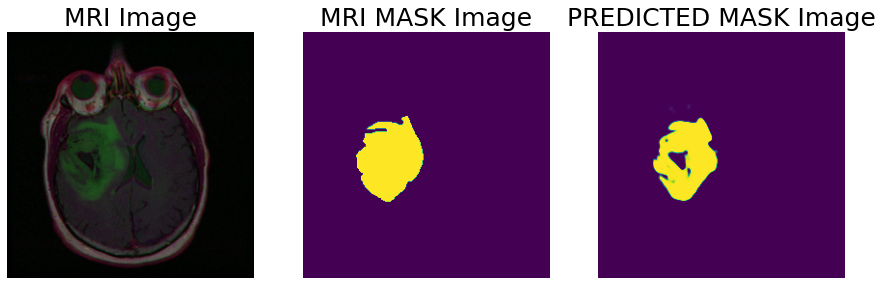

In [117]:
idx=12
show_img(images[idx],masks[idx],m)

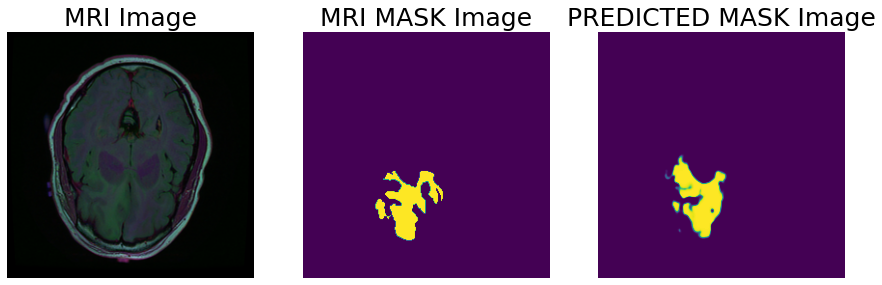

In [119]:
idx=11
show_img(images[idx],masks[idx],m)

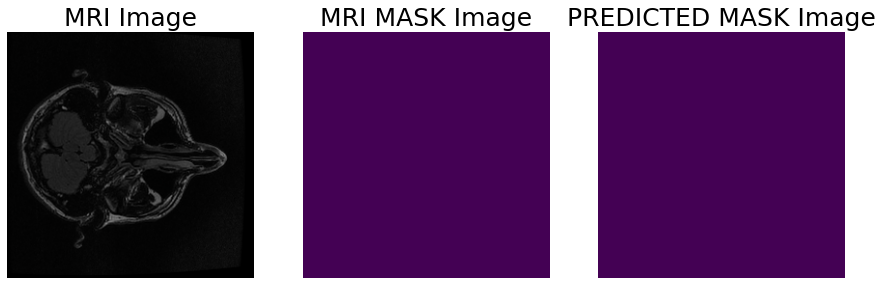

In [132]:
idx=5
show_img(images[idx],masks[idx],m)

In [21]:
img=np.zeros((5,5))

In [22]:
img

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [23]:
img[img<0.5]=1

In [24]:
img

array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.]])